In [15]:
import os, sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.environ['PYTHONPATH'] = project_root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("PYTHONPATH manually set to:", os.environ['PYTHONPATH'])

PYTHONPATH manually set to: c:\Users\ndhaj\Desktop\GraphicalPR


In [16]:
import numpy as np
import matplotlib.pyplot as plt

from graph.structure import Graph
from graph.prior import GaussianPrior, SupportPrior, SparsePrior, ConstWave
from graph.propagator import UnitaryPropagator, FFT2DPropagator, PhaseMaskPropagator
from graph.measurement import GaussianMeasurement, AmplitudeMeasurement
from core.metrics import mse, pmse
from core.linalg_utils import *

In [17]:
H, W = 128, 128
shape = (H, W)
a = random_normal_array(shape)
var = 1e-4

class AddTestGraph(Graph):
    def __init__(self):
        super().__init__()
        # Assign labeled priors
        A = ConstWave(data = a, label="A")
        B = GaussianPrior(var=1.0, shape=shape, label="B")
        # Add intermediate and output factors
        self.meas = GaussianMeasurement(var=var) @ (A + B)
        # Compile
        self.compile()

In [18]:
# ==== Initialization ====
g = AddTestGraph()

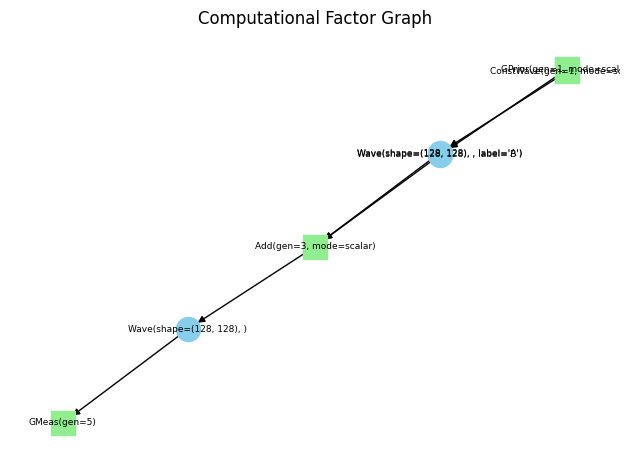

In [19]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)

In [20]:
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)

In [21]:
true_a = g.get_wave("B").get_sample()

In [22]:
def monitor(graph, t):
    B = graph.get_wave("B")
    est = B.compute_belief().data
    err = mse(est, true_a)
    if t % 10 == 0:
        print(f"[t={t}] MSE = {err:.5e}")

In [23]:
g.run(n_iter=100, callback=monitor)

BP Iteration: 100%|██████████| 100/100 [00:00<00:00, 3829.85it/s]

[t=0] MSE = 1.99412e+00
[t=10] MSE = 2.00169e-04
[t=20] MSE = 2.00169e-04
[t=30] MSE = 2.00169e-04
[t=40] MSE = 2.00169e-04
[t=50] MSE = 2.00169e-04
[t=60] MSE = 2.00169e-04
[t=70] MSE = 2.00169e-04
[t=80] MSE = 2.00169e-04
[t=90] MSE = 2.00169e-04


## Holography

BP Iteration:  37%|███▋      | 74/200 [00:00<00:00, 711.49it/s]

[t=0] PMSE = 1.43902e+00
[t=20] PMSE = 1.02118e-04
[t=40] PMSE = 1.02055e-04
[t=60] PMSE = 1.02054e-04
[t=80] PMSE = 1.02054e-04
[t=100] PMSE = 1.02054e-04
[t=120] PMSE = 1.02054e-04
[t=140] PMSE = 1.02054e-04


BP Iteration: 100%|██████████| 200/200 [00:00<00:00, 718.56it/s]


[t=160] PMSE = 1.02054e-04
[t=180] PMSE = 1.02054e-04


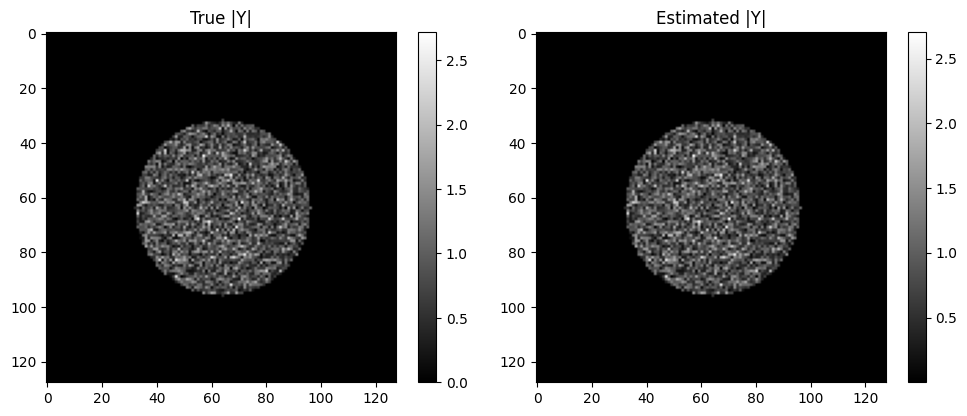

In [24]:
# ==== Imports ====
import numpy as np
import matplotlib.pyplot as plt

from core.linalg_utils import random_normal_array, circular_aperture
from graph.structure.graph import Graph
from graph.prior.const_wave import ConstWave
from graph.prior.support_prior import SupportPrior
from graph.propagator.add_propagator import AddPropagator
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from core.metrics import pmse

# ==== 1. パラメータ ====
H, W = 128, 128
shape = (H, W)
support_radius = 0.25
var = 1e-4
large_value = 1e6
rng = np.random.default_rng(seed=42)

# Known reference wave
x_ref = random_normal_array(shape, dtype=np.complex128, rng=rng)

# Support mask
support = circular_aperture(shape, radius=support_radius)

# ==== 2. グラフ定義 ====
class HolographySupportGraph(Graph):
    def __init__(self):
        super().__init__()
        self.X = ConstWave(data=x_ref, large_value=large_value, label="X_ref")
        self.Y = SupportPrior(support=support, label="Y_unknown")
        self.W = AddPropagator() @ (self.X, self.Y)
        self.Z = FFT2DPropagator(shape) @ self.W
        self.meas = AmplitudeMeasurement(var=var, damping=0.2) @ self.Z
        self.compile()

# ==== 3. 初期化と推論 ====
g = HolographySupportGraph()
g.set_init_rng(np.random.default_rng(seed=1))
g.generate_sample(rng=np.random.default_rng(seed=999), update_observed=True)

true_y = g.get_wave("Y_unknown").get_sample()

def monitor(graph, t):
    est = graph.get_wave("Y_unknown").compute_belief().data
    err = pmse(est, true_y)
    if t % 20 == 0:
        print(f"[t={t}] PMSE = {err:.5e}")

g.run(n_iter=200, callback=monitor)

# ==== 4. 可視化 ====
est = g.get_wave("Y_unknown").compute_belief().data

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("True |Y|")
plt.imshow(np.abs(true_y), cmap='gray')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Estimated |Y|")
plt.imshow(np.abs(est), cmap='gray')
plt.colorbar()
plt.tight_layout()
plt.show()


In [25]:
%prun -l 40 -s cumulative g.run(n_iter=200, callback=None)

BP Iteration: 100%|██████████| 200/200 [00:00<00:00, 784.70it/s]

         87952 function calls in 0.256 seconds

   Ordered by: cumulative time
   List reduced from 221 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.256    0.256 {built-in method builtins.exec}
        1    0.000    0.000    0.256    0.256 <string>:1(<module>)
        1    0.000    0.000    0.256    0.256 graph.py:136(run)
      200    0.001    0.000    0.218    0.001 graph.py:131(backward)
      200    0.000    0.000    0.130    0.001 fft_2d_propagator.py:104(backward)
      200    0.018    0.000    0.107    0.001 fft_2d_propagator.py:55(compute_belief)
      400    0.001    0.000    0.062    0.000 _pocketfft.py:701(_raw_fftnd)
      200    0.000    0.000    0.060    0.000 base.py:129(backward)
      200    0.001    0.000    0.058    0.000 amplitude_measurement.py:84(_compute_message)
      800    0.001    0.000    0.055    0.000 _pocketfft.py:49(_raw_fft)
      800    0.053    0.000    0.053   

In [26]:
import numpy as np
import matplotlib.pyplot as plt

from graph.structure import Graph
from graph.prior.support_prior import SupportPrior
from graph.measurement.amplitude_measurement import AmplitudeMeasurement
from graph.propagator.fft_2d_propagator import FFT2DPropagator
from graph.propagator.add_propagator import AddPropagator

from core.linalg_utils import *
from core.metrics import pmse

# ==== Setting Parameter ====
H, W = 256, 256
shape = (H, W)
var = 1e-4
rng = np.random.default_rng(seed=42)
support_x = circular_aperture(shape=(128, 128), radius=0.15, center=(-0.25, -0.25))
data_x = masked_random_array(support, dtype=np.complex128, rng=rng)
support_y =  circular_aperture(shape=(128, 128), radius=0.25, center=(0.25, 0.25))

# ==== Graph ====
class HolographicCDI(Graph):
    def __init__(self):
        super().__init__()
        X = ConstWave(data_x, label="X")
        Y = SupportPrior(support = support_y, label="Y")
        self.meas = AmplitudeMeasurement(var = var, damping = 0.0) @ (FFT2DPropagator() @ (X + Y))
        self.compile()

# ==== グラフ構築・サンプル生成 ====
g = HolographicCDI()
g.set_init_rng(np.random.default_rng(seed=12))
g.generate_sample(rng=np.random.default_rng(seed=99), update_observed=True)

true_y = g.get_wave("Y").get_sample()

# ==== 推論ループ ====
def monitor(graph, t):
    y = graph.get_wave("Y").compute_belief().data
    err = pmse(y, true_y)
    print(f"[t={t}] PMSE (sum) = {err:.5e}")

g.run(n_iter=20, callback=monitor)


BP Iteration: 100%|██████████| 20/20 [00:00<00:00, 545.61it/s]

[t=0] PMSE (sum) = 1.34353e+00
[t=1] PMSE (sum) = 2.37798e-01
[t=2] PMSE (sum) = 9.91398e-02
[t=3] PMSE (sum) = 3.41368e-02
[t=4] PMSE (sum) = 1.23770e-02
[t=5] PMSE (sum) = 4.88530e-03
[t=6] PMSE (sum) = 2.04384e-03
[t=7] PMSE (sum) = 1.03904e-03
[t=8] PMSE (sum) = 5.73527e-04
[t=9] PMSE (sum) = 3.37069e-04
[t=10] PMSE (sum) = 2.00656e-04
[t=11] PMSE (sum) = 1.38394e-04
[t=12] PMSE (sum) = 1.15575e-04
[t=13] PMSE (sum) = 1.07077e-04
[t=14] PMSE (sum) = 1.03515e-04
[t=15] PMSE (sum) = 1.02348e-04
[t=16] PMSE (sum) = 1.01566e-04
[t=17] PMSE (sum) = 1.01338e-04
[t=18] PMSE (sum) = 1.01080e-04
[t=19] PMSE (sum) = 1.01036e-04


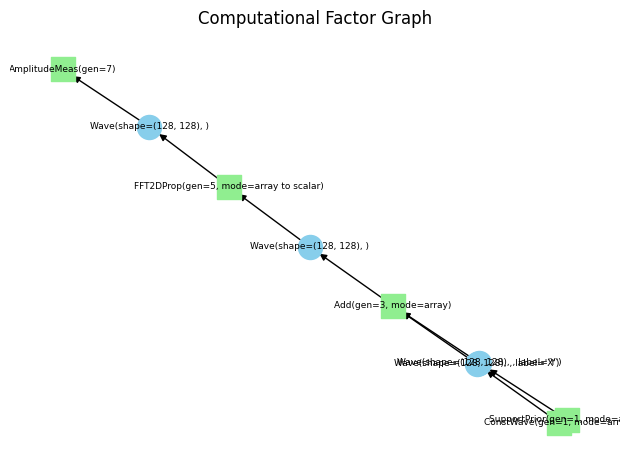

In [27]:
g.visualize(layout="kamada_kawai", font_size=6.5, scale=2.0)